# Rendering FLAME reconstructed vertices using pyrender

In [11]:
import os
os.environ['DISPLAY'] = ':0.0'  # need for deepnet

import trimesh
import numpy as np
import matplotlib.pyplot as plt
from pyrender import Scene, Mesh, OffscreenRenderer
from pyrender import SpotLight, OrthographicCamera, Node, DirectionalLight
from skimage.transform import warp

np.set_printoptions(suppress=True)

In [23]:
d = np.load('../emoca_align.npz')
v = d['v']
mat = d['mat']
f = np.load('../gmfx/data/faces_flame.npy')

cam_mat = np.eye(4)
cam_mat[2, 3] = 4
cam_mat = np.linalg.inv(mat) @ cam_mat

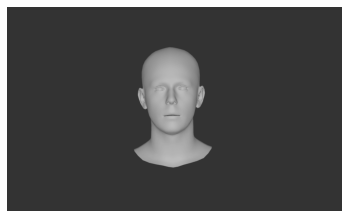

In [24]:
# Create pyrender-compatible mesh
mesh = trimesh.Trimesh(v[:, :3], f)
mesh_pr = Mesh.from_trimesh(mesh)

# Create scene and add head
scene = Scene(bg_color=[0, 0, 0])
head = Node(mesh=mesh_pr)
scene.add_node(head)

zoom_out = 4
camera = Node(camera=OrthographicCamera(xmag=1, ymag=1), matrix=cam_mat)
scene.add_node(camera)

# Create spotlight, directly in front of head (so need to translate)
# Also zoom out in z-direction
light = DirectionalLight(intensity=5)#SpotLight(intensity=50)
scene.add_node(Node(light=light, matrix=cam_mat))

# Create renderer with viewport of the same size as original image
r = OffscreenRenderer(viewport_width=1280, viewport_height=780)
color, depth = r.render(scene)

#plt.imshow(img_orig)
plt.imshow(color, alpha=0.8)
plt.axis('off');

Load some example data, containing the original image (`img_orig`), cropped image (`img_crop`, which is passed to EMOCA), the reconstructed vertices (`v`) and the faces/polygons (`f`), as well as the cropping transformation matrix (`tform`), which is used to map the orignal image to the cropped image.

In [4]:
d = np.load('../example_recon_data.npz')
v, f, tform = d['v'], d['f'], d['tform']
img_orig = d['img_orig']
img_crop = d['img_crop'].astype(np.uint8)

dim_orig = img_orig.shape
dim_crop = img_crop.shape

fig, axes = plt.subplots(ncols=2)
axes[0].imshow(img_orig)
axes[1].imshow(img_crop)
for ax in axes:
    ax.axis('off')

FileNotFoundError: [Errno 2] No such file or directory: '../example_recon_data.npz'

## Plot in cropped image space
Now, plotting the reconstructed mesh in the cropped image space is very simple. Note that the estimated translation and scale parameters are already applied to `v`.

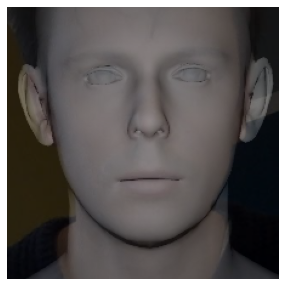

In [51]:
# Create pyrender-compatible mesh
mesh = trimesh.Trimesh(v, f)
mesh_pr = Mesh.from_trimesh(mesh)

# Create scene and add head
scene = Scene(bg_color=[0, 0, 0])
head = Node(mesh=mesh_pr)
scene.add_node(head)

zoom_out = 5
# Create orthographic camera (because DECA/EMOCA assumes this;
# not sure what to do with `xmag` and `ymag`)
camera = OrthographicCamera(xmag=1, ymag=1)
scene.add_node(Node(camera=camera, translation=(0, 0, zoom_out)))

# Create spotlight, directly in front of head (so need to translate)
# Also zoom out in z-direction
light = SpotLight(intensity=50)
scene.add_node(Node(light=light, translation=(0, 0, zoom_out)))

# Create renderer with viewport of the same size as original image
r = OffscreenRenderer(viewport_width=dim_crop[0], viewport_height=dim_crop[1])
color, depth = r.render(scene)
r.delete()

# Plot original (cropped) image and reconstructed head
plt.figure(figsize=(5,5))
plt.imshow(img_crop)
plt.imshow(color, alpha=0.8)
plt.axis('off')
plt.show()

## Plot in original image space
Visualizing the reconstruction in the original image space is a bit harder, because the vertices are reconstructed in the cropped image space. The `tform` variable contains the cropped-to-orig matrix estimated using the `SimilarityTransform` class from `skimage`. So one thing we could do is to just warp the *rendered image*, as done below: 

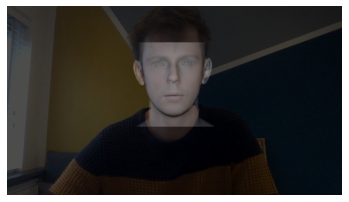

In [52]:
color_orig = warp(color, tform, output_shape=dim_orig, preserve_range=True)

plt.imshow(img_orig)
plt.imshow(color_orig.astype(np.uint8), alpha=0.7)
plt.axis('off')
plt.show()

However, this is suboptimal for a couple of reasons. Most importantly, the rendered image does not contain the entire face, which looks a bit weird when transformed to the original image space. What they do in the original DECA (and EMOCA) code is the following (as far as I understand):

* Map X/Y coordinates to the cropped image space
* Apply the transform
* Map the X/Y coordinates, which are now in the oroginal image space, back to camera (?) space
* Render as usual

The DECA code that does this is in `transform_points`: [https://github.com/YadiraF/DECA/blob/master/decalib/utils/tensor_cropper.py#L118](https://github.com/YadiraF/DECA/blob/master/decalib/utils/tensor_cropper.py#L118). Here, `points_scale` refers to the cropped image dimensions (i.e., 224) and `out_scale` is the original image dimensions (780x1280 in this case). I tried to implement this below, but I couldn't seem to make it work ...

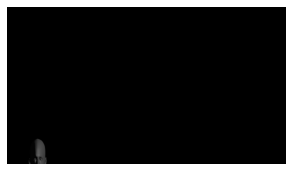

In [99]:
v_ = (v[:, :2] * .5 + .5) * dim_crop[0]
v_ = np.c_[v_, np.ones(5023)] @ tform
v_[:, 0] = v_[:, 0] / dim_orig[1] * 2 - 1
v_[:, 1] = v_[:, 1] / dim_orig[0] * 2 - 1
v_ = np.c_[v_[:, :2], v[:, 2]]
#v_ = np.c_[v_, np.ones(5023)] @ camera.get_projection_matrix().T
#v_ = v_ / v_[:, 3, None]
#print(v_.min(axis=0), v_.max(axis=0))

mesh = trimesh.Trimesh(v_, f)
mesh_pr = Mesh.from_trimesh(mesh)

scene = Scene(bg_color=[0, 0, 0])
head = Node(mesh=mesh_pr)
scene.add_node(head)

zoom_out = 4
camera = OrthographicCamera(xmag=1, ymag=1)
scene.add_node(Node(camera=camera, translation=(0, 0, zoom_out)))
light = SpotLight(intensity=50)
scene.add_node(Node(light=light, translation=(0, 0, zoom_out)))

r = OffscreenRenderer(viewport_width=dim_orig[1], viewport_height=dim_orig[0])
color, depth = r.render(scene)
r.delete()

# Plot original (cropped) image and reconstructed head
plt.figure(figsize=(5,5))
#plt.imshow(img_orig)
plt.imshow(color, alpha=1)
plt.axis('off')
plt.show()

In [78]:
camera.get_projection_matrix()

array([[ 1.        ,  0.        ,  0.        ,  0.        ],
       [ 0.        ,  1.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        , -0.02001001, -1.0010005 ],
       [ 0.        ,  0.        ,  0.        ,  1.        ]])

# 